In [ ]:
# Шаг 1.1: Подключение Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Шаг 1.2: Проверка доступности GPU
!nvidia-smi

# Шаг 1.3: Установка переменной для пути к датасету

import os
base_dataset_dir = "/content/drive/MyDrive/KazakhFoodDataset"

# Проверяем, что папка существует и выводим список подкатегорий (названия блюд)
if os.path.exists(base_dataset_dir):
    categories = os.listdir(base_dataset_dir)
    print("Найденные категории (папки):")
    for cat in categories:
        print("-", cat)
else:
    print("Папка с датасетом не найдена. Проверьте путь:", base_dataset_dir)

Mounted at /content/drive
Mon Mar 10 05:48:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------

In [ ]:
# Шаг 1.4: (Опционально) Автоматическое разбиение датасета на train, val и test
# Если у вас датасет ещё не разбит, выполните следующий код.
# Это создаст папки data/train, data/val и data/test в вашем Google Drive.
import random
import shutil

# Задаем пути для новых разделенных данных
split_base_dir = "/content/drive/MyDrive/data"
train_dir = os.path.join(split_base_dir, "train")
val_dir   = os.path.join(split_base_dir, "val")
test_dir  = os.path.join(split_base_dir, "test")

# Создаем директории, если их еще нет
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Разбиваем каждый класс (папку) на 70% train, 15% val, 15% test
for category in categories:
    category_path = os.path.join(base_dataset_dir, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        random.shuffle(images)

        train_split = int(0.7 * len(images))
        val_split   = int(0.85 * len(images))

        train_images = images[:train_split]
        val_images   = images[train_split:val_split]
        test_images  = images[val_split:]

        # Создаем соответствующие папки для каждой категории в train/val/test
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # Функция для копирования файлов
        def copy_images(img_list, src_folder, dst_folder):
            for img in img_list:
                src_path = os.path.join(src_folder, img)
                dst_path = os.path.join(dst_folder, img)
                shutil.copy(src_path, dst_path)

        copy_images(train_images, category_path, os.path.join(train_dir, category))
        copy_images(val_images, category_path, os.path.join(val_dir, category))
        copy_images(test_images, category_path, os.path.join(test_dir, category))

print("Разделение датасета завершено.")
print("Тренировочная выборка:", sum([len(os.listdir(os.path.join(train_dir, cat))) for cat in os.listdir(train_dir)]))
print("Валидационная выборка:", sum([len(os.listdir(os.path.join(val_dir, cat))) for cat in os.listdir(val_dir)]))
print("Тестовая выборка:", sum([len(os.listdir(os.path.join(test_dir, cat))) for cat in os.listdir(test_dir)]))


Разделение датасета завершено.
Тренировочная выборка: 6695
Валидационная выборка: 1437
Тестовая выборка: 1447


In [ ]:
# Импортируем необходимые библиотеки
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Определяем преобразования (аугментацию) для обучающего набора
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                      # Приводим изображения к размеру 224x224
    transforms.RandomHorizontalFlip(),                  # Случайное горизонтальное отражение
    transforms.RandomRotation(15),                      # Случайное вращение ±15°
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Небольшие изменения яркости и контраста
    transforms.ToTensor(),                              # Преобразуем изображение в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406],     # Нормализация по стандарту ImageNet
                         std=[0.229, 0.224, 0.225])
])

# 2. Преобразования для валидационного и тестового наборов (без аугментации)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                      # Приводим изображения к размеру 224x224
    transforms.ToTensor(),                              # Преобразуем изображение в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 3. Задаем пути к директориям обучающего, валидационного и тестового наборов
train_dir = "/content/drive/MyDrive/data/train"
val_dir   = "/content/drive/MyDrive/data/val"
test_dir  = "/content/drive/MyDrive/data/test"

# 4. Загружаем данные с использованием ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=val_dir, transform=val_transforms)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=val_transforms)

# Выведем информацию о классах и количестве изображений
print("Классы:", train_dataset.classes)
print("Количество изображений в train:", len(train_dataset))
print("Количество изображений в val:", len(val_dataset))
print("Количество изображений в test:", len(test_dataset))

Классы: ['ásip', 'baýyrsaq', 'beshbarmaq', 'irimshik', 'manty', 'naryn', 'naýryz_kóje', 'orama', 'plain_soup', 'plov', 'qattama nan', 'qazy-qarta', 'qurt', 'qymyz', 'qýyrdaq', 'samsa', 'sheep_head', 'shelpek', 'shorpa', 'súzbe', 'taba-nan', 'talqan-jent']
Количество изображений в train: 6683
Количество изображений в val: 1434
Количество изображений в test: 1440


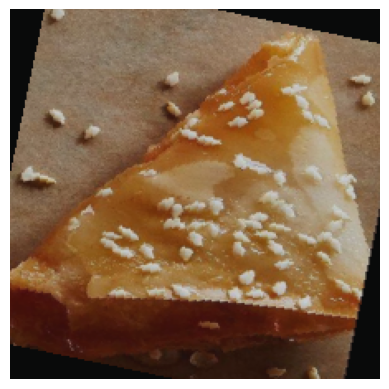

Метка: samsa


In [ ]:
# 5. Создаем DataLoader для загрузки данных батчами
batch_size = 32  # Можно менять значение в зависимости от объема памяти GPU

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 6. Функция для визуализации одного изображения (для проверки корректности загрузки)
def imshow(img):
    # Функция возвращает изображение в нормальный вид (отмена нормализации)
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# 7. Проверяем DataLoader: выводим одно изображение из обучающего набора
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(images[0])
print("Метка:", train_dataset.classes[labels[0]])

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Указываем количество классов (22 блюда)
num_classes = 22

# Определяем устройство: GPU (если доступно) или CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Инициализация модели ResNet50
model_resnet = models.resnet50(pretrained=True)
num_ftrs_resnet = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs_resnet, num_classes)
model_resnet = model_resnet.to(device)

# 2. Инициализация модели EfficientNet-B0
model_efficientnet = models.efficientnet_b0(pretrained=True)
num_ftrs_efficientnet = model_efficientnet.classifier[1].in_features
model_efficientnet.classifier[1] = nn.Linear(num_ftrs_efficientnet, num_classes)
model_efficientnet = model_efficientnet.to(device)

# 3. Инициализация модели VGG16
model_vgg = models.vgg16(pretrained=True)
num_ftrs_vgg = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs_vgg, num_classes)
model_vgg = model_vgg.to(device)

# 4. Инициализация модели MobileNet_v2
model_mobilenet = models.mobilenet_v2(pretrained=True)
num_ftrs_mobilenet = model_mobilenet.classifier[1].in_features
model_mobilenet.classifier[1] = nn.Linear(num_ftrs_mobilenet, num_classes)
model_mobilenet = model_mobilenet.to(device)

# 5. Инициализация модели DenseNet121
model_densenet = models.densenet121(pretrained=True)
num_ftrs_densenet = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(num_ftrs_densenet, num_classes)
model_densenet = model_densenet.to(device)

print("Все 5 моделей инициализированы и перенесены на устройство:", device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

Все 5 моделей инициализированы и перенесены на устройство: cuda


In [ ]:
# Гиперпараметры
num_epochs = 15  # Количество эпох
batch_size = 32  # Размер батча
learning_rate = 0.0001  # Скорость обучения

In [ ]:
import torch.optim as optim

# Функция потерь (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# Оптимизаторы для каждой модели
optimizers = {
    "resnet50": optim.Adam(model_resnet.parameters(), lr=learning_rate),
    "efficientnet_b0": optim.Adam(model_efficientnet.parameters(), lr=learning_rate),
    "vgg16": optim.Adam(model_vgg.parameters(), lr=learning_rate),
    "mobilenet_v2": optim.Adam(model_mobilenet.parameters(), lr=learning_rate),
    "densenet121": optim.Adam(model_densenet.parameters(), lr=learning_rate),
}

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Обнуляем градиенты
        outputs = model(images)  # Прямой проход
        loss = criterion(outputs, labels)  # Вычисляем потери
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновляем веса модели

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

In [ ]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Отключаем градиенты
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [ ]:
import copy

# Словарь для хранения лучшей модели
best_models = {}

for model_name, model in [("resnet50", model_resnet),
                          ("efficientnet_b0", model_efficientnet),
                          ("vgg16", model_vgg),
                          ("mobilenet_v2", model_mobilenet),
                          ("densenet121", model_densenet)]:

    optimizer = optimizers[model_name]
    best_val_acc = 0.0  # Для отслеживания лучшей точности на валидации
    best_model_wts = copy.deepcopy(model.state_dict())

    print(f"\n🔹 Обучение модели {model_name}...")

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        print(f"🔹 Эпоха {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Сохраняем лучшую модель
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    # Сохраняем лучшую версию модели
    model.load_state_dict(best_model_wts)
    best_models[model_name] = model.state_dict()

    print(f"✅ Лучший результат {model_name}: {best_val_acc:.2f}%")


🔹 Обучение модели resnet50...
🔹 Эпоха 1/15 | Train Loss: 0.7941, Train Acc: 77.57% | Val Loss: 0.3931, Val Acc: 87.66%
🔹 Эпоха 2/15 | Train Loss: 0.3289, Train Acc: 89.87% | Val Loss: 0.3169, Val Acc: 90.10%
🔹 Эпоха 3/15 | Train Loss: 0.2338, Train Acc: 92.50% | Val Loss: 0.2985, Val Acc: 90.38%
🔹 Эпоха 4/15 | Train Loss: 0.1869, Train Acc: 94.13% | Val Loss: 0.2426, Val Acc: 91.70%
🔹 Эпоха 5/15 | Train Loss: 0.1332, Train Acc: 95.89% | Val Loss: 0.2320, Val Acc: 92.96%
🔹 Эпоха 6/15 | Train Loss: 0.1171, Train Acc: 96.35% | Val Loss: 0.2350, Val Acc: 93.31%
🔹 Эпоха 7/15 | Train Loss: 0.0960, Train Acc: 97.07% | Val Loss: 0.2632, Val Acc: 92.33%
🔹 Эпоха 8/15 | Train Loss: 0.0993, Train Acc: 96.96% | Val Loss: 0.2897, Val Acc: 91.91%
🔹 Эпоха 9/15 | Train Loss: 0.0995, Train Acc: 96.83% | Val Loss: 0.2696, Val Acc: 92.05%
🔹 Эпоха 10/15 | Train Loss: 0.1014, Train Acc: 96.75% | Val Loss: 0.3112, Val Acc: 91.35%
🔹 Эпоха 11/15 | Train Loss: 0.0816, Train Acc: 97.55% | Val Loss: 0.2834, Val 

In [ ]:
# Сохраняем все лучшие модели в один файл (словарь best_models)
import torch

save_path = "/content/drive/MyDrive/best_models.pth"  # Путь для сохранения на Google Диске
torch.save(best_models, save_path)
print(f"Лучшие модели сохранены по адресу: {save_path}")

Лучшие модели сохранены по адресу: /content/drive/MyDrive/best_models.pth



--- Результаты для модели: resnet50 ---
               precision    recall  f1-score   support

        ásip       0.94      0.76      0.84        21
    baýyrsaq       0.73      0.97      0.83        68
   beshbarmaq       0.89      0.96      0.92       116
     irimshik       0.95      0.95      0.95        96
        manty       0.93      0.98      0.95        63
        naryn       0.89      0.91      0.90        46
naýryz_kóje       0.92      1.00      0.96        34
        orama       0.97      0.82      0.89        44
   plain_soup       0.98      0.89      0.93        62
         plov       0.98      0.98      0.98        99
  qattama nan       0.81      0.91      0.86        69
   qazy-qarta       0.77      0.79      0.78        34
         qurt       0.93      0.90      0.91        58
        qymyz       0.91      0.98      0.95        53
     qýyrdaq       0.97      0.85      0.90        67
        samsa       0.93      0.89      0.91       115
   sheep_head       1.0

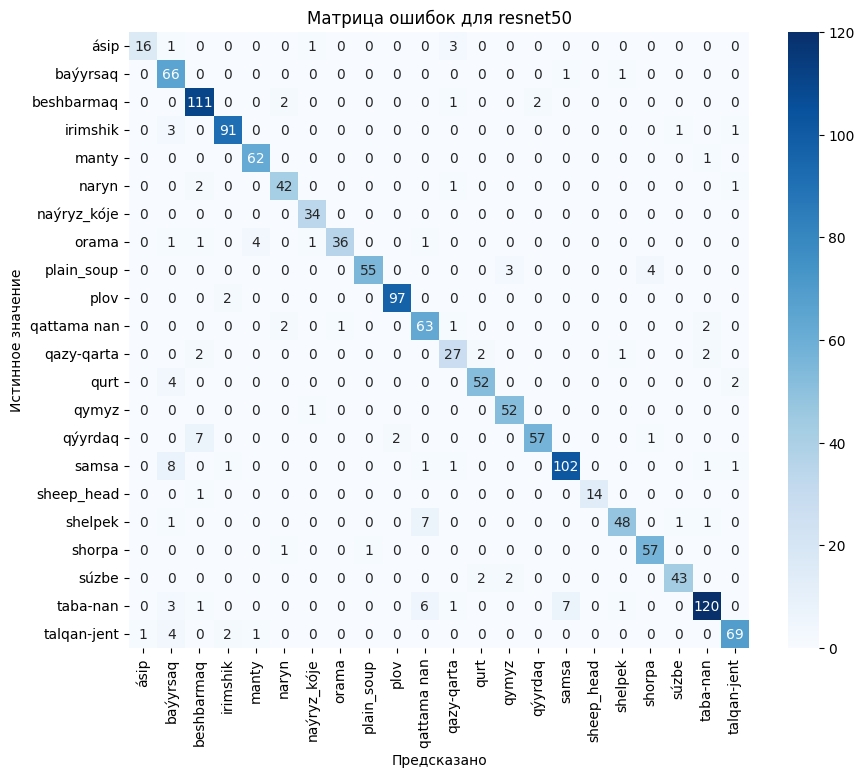


--- Результаты для модели: efficientnet_b0 ---
               precision    recall  f1-score   support

        ásip       0.89      0.81      0.85        21
    baýyrsaq       0.90      0.96      0.93        68
   beshbarmaq       0.95      0.97      0.96       116
     irimshik       0.95      0.99      0.97        96
        manty       0.95      0.97      0.96        63
        naryn       0.96      0.98      0.97        46
naýryz_kóje       0.94      1.00      0.97        34
        orama       0.93      0.84      0.88        44
   plain_soup       1.00      0.90      0.95        62
         plov       0.99      1.00      0.99        99
  qattama nan       0.88      0.88      0.88        69
   qazy-qarta       0.82      0.91      0.86        34
         qurt       0.89      0.97      0.93        58
        qymyz       0.96      0.98      0.97        53
     qýyrdaq       0.98      0.93      0.95        67
        samsa       0.98      0.93      0.96       115
   sheep_head   

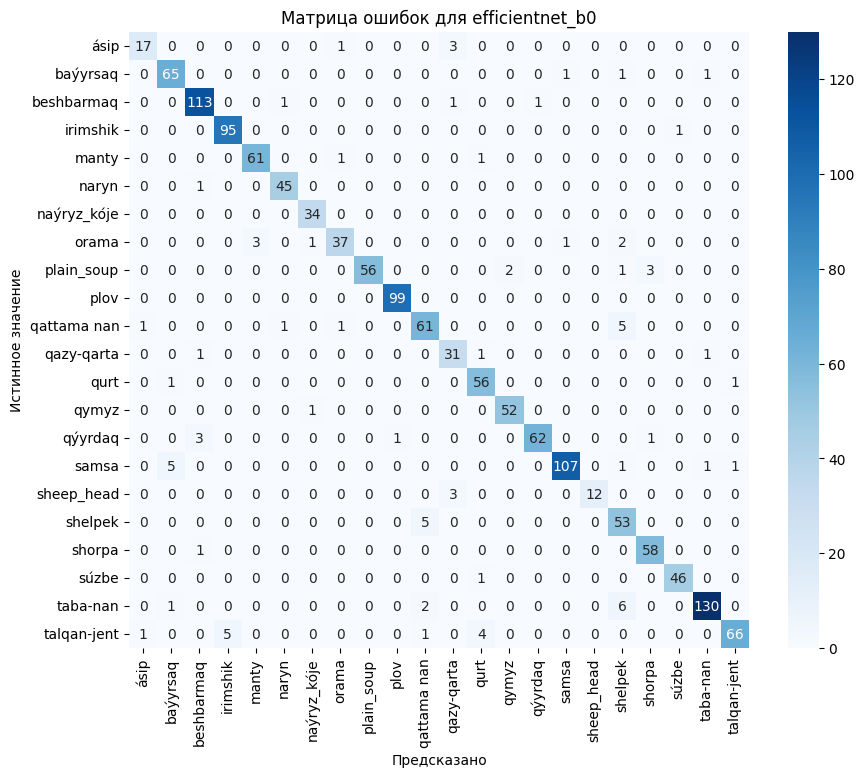


--- Результаты для модели: vgg16 ---
               precision    recall  f1-score   support

        ásip       0.92      0.57      0.71        21
    baýyrsaq       0.83      0.96      0.89        68
   beshbarmaq       0.81      0.96      0.88       116
     irimshik       0.87      0.94      0.90        96
        manty       0.89      0.94      0.91        63
        naryn       1.00      0.91      0.95        46
naýryz_kóje       0.89      0.94      0.91        34
        orama       0.79      0.61      0.69        44
   plain_soup       0.96      0.87      0.92        62
         plov       0.96      0.97      0.96        99
  qattama nan       0.82      0.88      0.85        69
   qazy-qarta       0.81      0.88      0.85        34
         qurt       0.83      0.98      0.90        58
        qymyz       0.88      0.96      0.92        53
     qýyrdaq       0.90      0.91      0.90        67
        samsa       0.93      0.89      0.91       115
   sheep_head       1.00  

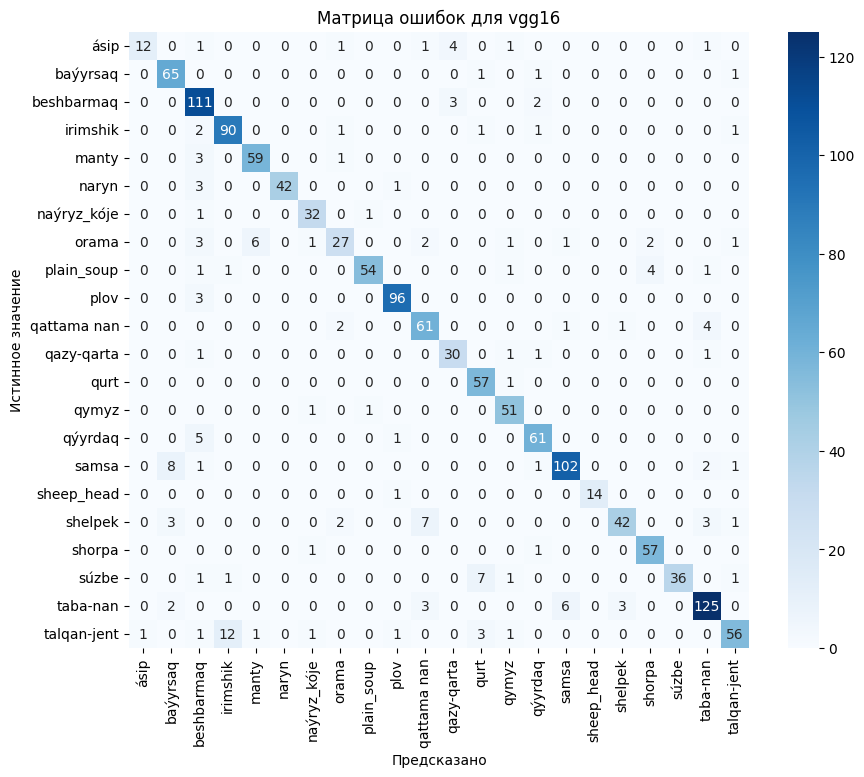


--- Результаты для модели: mobilenet_v2 ---
               precision    recall  f1-score   support

        ásip       0.94      0.81      0.87        21
    baýyrsaq       0.94      0.93      0.93        68
   beshbarmaq       0.95      0.91      0.93       116
     irimshik       0.97      0.95      0.96        96
        manty       0.94      0.92      0.93        63
        naryn       0.83      0.98      0.90        46
naýryz_kóje       0.94      1.00      0.97        34
        orama       0.92      0.82      0.87        44
   plain_soup       1.00      0.79      0.88        62
         plov       0.99      1.00      0.99        99
  qattama nan       0.82      0.91      0.86        69
   qazy-qarta       0.75      0.88      0.81        34
         qurt       0.83      0.98      0.90        58
        qymyz       0.91      0.98      0.95        53
     qýyrdaq       0.97      0.88      0.92        67
        samsa       0.95      0.97      0.96       115
   sheep_head      

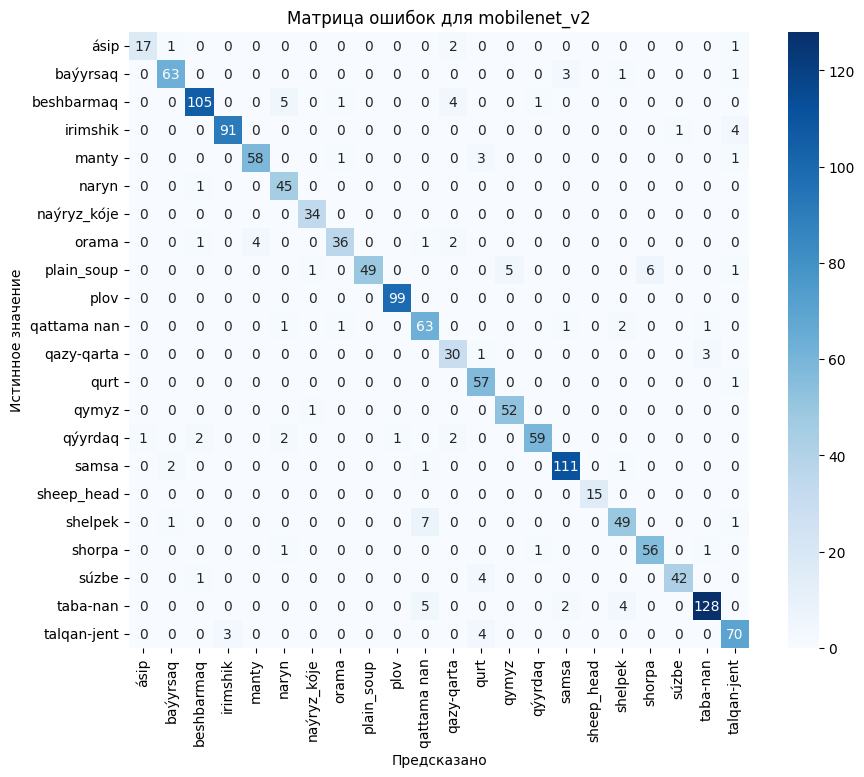


--- Результаты для модели: densenet121 ---
               precision    recall  f1-score   support

        ásip       1.00      0.76      0.86        21
    baýyrsaq       0.84      0.96      0.90        68
   beshbarmaq       0.96      0.93      0.95       116
     irimshik       0.97      0.99      0.98        96
        manty       0.95      0.98      0.97        63
        naryn       0.92      0.96      0.94        46
naýryz_kóje       0.94      1.00      0.97        34
        orama       0.95      0.86      0.90        44
   plain_soup       0.97      0.95      0.96        62
         plov       0.98      0.98      0.98        99
  qattama nan       0.89      0.93      0.91        69
   qazy-qarta       0.83      0.88      0.86        34
         qurt       0.93      0.95      0.94        58
        qymyz       0.96      0.98      0.97        53
     qýyrdaq       0.96      0.96      0.96        67
        samsa       0.98      0.95      0.96       115
   sheep_head       

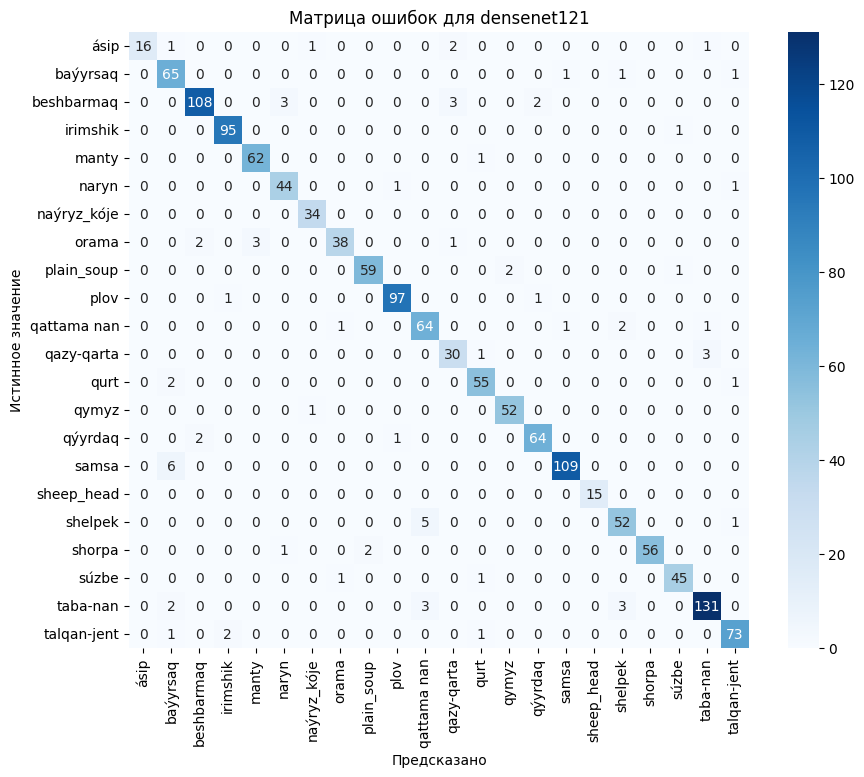

In [ ]:
# Шаг 5: Оценка и сравнение моделей на тестовом наборе
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Словарь с нашими моделями, которые мы инициализировали ранее
models_dict = {
    "resnet50": model_resnet,
    "efficientnet_b0": model_efficientnet,
    "vgg16": model_vgg,
    "mobilenet_v2": model_mobilenet,
    "densenet121": model_densenet,
}

# Функция для оценки модели на тестовом наборе
def evaluate_model(model, dataloader, device):
    model.eval()  # Переводим модель в режим инференса
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Оценка каждой модели и вывод метрик
for model_name, model in models_dict.items():
    # Загружаем лучшие веса для данной модели
    model.load_state_dict(best_models[model_name])

    # Получаем предсказания на тестовом наборе
    true_labels, predictions = evaluate_model(model, test_loader, device)

    print(f"\n--- Результаты для модели: {model_name} ---")
    # Выводим отчёт классификации
    print(classification_report(true_labels, predictions, target_names=test_dataset.classes))

    # Вычисляем матрицу ошибок
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.title(f"Матрица ошибок для {model_name}")
    plt.xlabel("Предсказано")
    plt.ylabel("Истинное значение")
    plt.show()

In [ ]:
import torch.optim as optim

# 6.1. Подготавливаем модель для дополнительного обучения
# Загружаем DenseNet121 и заменяем классификатор для 22 классов
model_finetune = models.densenet121(pretrained=False)
num_ftrs = model_finetune.classifier.in_features
model_finetune.classifier = nn.Linear(num_ftrs, num_classes)
# Загружаем ранее сохраненные лучшие веса для DenseNet121
model_finetune.load_state_dict(best_models["densenet121"])
model_finetune = model_finetune.to(device)

# 6.2. Разблокируем все слои для дообучения
for param in model_finetune.parameters():
    param.requires_grad = True

# 6.3. Настраиваем оптимизатор с меньшей скоростью обучения для fine-tuning
optimizer_finetune = optim.Adam(model_finetune.parameters(), lr=1e-5)
# Дополнительно можно использовать планировщик (scheduler) для понижения скорости обучения
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_finetune, step_size=5, gamma=0.1)

# 6.4. Задаем количество дополнительных эпох дообучения
num_finetune_epochs = 10

print("Начинаем дополнительное дообучение (fine-tuning) DenseNet121...")

for epoch in range(num_finetune_epochs):
    train_loss, train_acc = train_one_epoch(model_finetune, train_loader, optimizer_finetune, criterion, device)
    val_loss, val_acc = validate(model_finetune, val_loader, criterion, device)
    scheduler.step()
    print(f"Fine-tune Epoch {epoch+1}/{num_finetune_epochs}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.2f}% | Val Loss {val_loss:.4f}, Val Acc {val_acc:.2f}%")

# После дообучения оцениваем модель на тестовом наборе
true_labels, predictions = evaluate_model(model_finetune, test_loader, device)
print("Оценка на тестовом наборе после fine-tuning:")
print(classification_report(true_labels, predictions, target_names=test_dataset.classes))

# Сохраняем дообученную модель
finetuned_model_path = "/content/drive/MyDrive/best_model_finetuned.pth"
torch.save(model_finetune.state_dict(), finetuned_model_path)
print("Fine-tuned модель сохранена по адресу:", finetuned_model_path)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Начинаем дополнительное дообучение (fine-tuning) DenseNet121...
Fine-tune Epoch 1/10: Train Loss 0.0178, Train Acc 99.75% | Val Loss 0.1777, Val Acc 94.63%
Fine-tune Epoch 2/10: Train Loss 0.0150, Train Acc 99.73% | Val Loss 0.1760, Val Acc 94.70%
Fine-tune Epoch 3/10: Train Loss 0.0127, Train Acc 99.87% | Val Loss 0.1749, Val Acc 94.63%
Fine-tune Epoch 4/10: Train Loss 0.0106, Train Acc 99.87% | Val Loss 0.1697, Val Acc 95.12%
Fine-tune Epoch 5/10: Train Loss 0.0093, Train Acc 99.87% | Val Loss 0.1746, Val Acc 95.19%
Fine-tune Epoch 6/10: Train Loss 0.0087, Train Acc 99.88% | Val Loss 0.1649, Val Acc 94.98%
Fine-tune Epoch 7/10: Train Loss 0.0070, Train Acc 99.91% | Val Loss 0.1720, Val Acc 94.77%
Fine-tune Epoch 8/10: Train Loss 0.0086, Train Acc 99.90% | Val Loss 0.1725, Val Acc 95.05%
Fine-tune Epoch 9/10: Train Loss 0.0071, Train Acc 99.93% | Val Loss 0.1725, Val Acc 94.91%
Fine-tune Epoch 10/10: Train Loss 0.0080, Train Acc 99.91% | Val Loss 0.1694, Val Acc 94.84%
Оценка на тесто

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 89.3 MB/s eta 0:00:00


In [ ]:
# Подготовка фиктивного входа (dummy input) для экспорта
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Экспорт модели в формат ONNX
onnx_model_path = "/content/drive/MyDrive/best_model_finetuned.onnx"
torch.onnx.export(
    model_finetune,           # наша дообученная модель
    dummy_input,              # пример входа
    onnx_model_path,          # путь для сохранения
    input_names=["input"],    # имя входного тензора
    output_names=["output"],  # имя выходного тензора
    opset_version=11          # версия ONNX opset
)
print("Модель экспортирована в ONNX по адресу:", onnx_model_path)


Модель экспортирована в ONNX по адресу: /content/drive/MyDrive/best_model_finetuned.onnx
